Basic Imports

In [1]:
# Install pydicom for DICOM image handling
!pip install pydicom
# Install opencv-python for image processing
!pip install opencv-python
print("Libraries installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 57.0 MB/s eta 0:00:00
Libraries installed.


In [2]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import os

import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
print("Libraries imported successfully.")

Mounted at /content/drive
Libraries imported successfully.


Unzipping Dataset

In [3]:
ZIP_PATH = "/content/drive/My Drive/datasets/rsna-pneumonia-detection-challenge.zip"
DATA_ROOT = "/content/drive/My Drive/rsna"

# Create local directory
os.makedirs(DATA_ROOT, exist_ok=True)

IMAGE_DIR = os.path.join(DATA_ROOT, "stage_2_train_images")
LABELS_CSV = os.path.join(DATA_ROOT, "stage_2_train_labels.csv")

# Unzip dataset
if not os.path.exists(IMAGE_DIR) or not os.path.exists(LABELS_CSV):
  !unzip -o -q "{ZIP_PATH}" -d "{DATA_ROOT}"

# Verify contents
print("Dataset contents:")
print(os.listdir(DATA_ROOT))

print("\nIMAGE_DIR exists?", os.path.exists(IMAGE_DIR))
print("LABELS_CSV exists?", os.path.exists(LABELS_CSV))

Dataset contents:
['stage_2_detailed_class_info.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_sample_submission.csv', 'stage_2_train_labels.csv', 'stage_2_test_images', 'stage_2_train_images', 'preprocessed_arrays', 'best_model.pth']

IMAGE_DIR exists? True
LABELS_CSV exists? True


In [4]:
DATA_PATH = DATA_ROOT
print(f"DATA_PATH set to: {DATA_ROOT}")

DATA_PATH set to: /content/drive/My Drive/rsna


Process Labels

In [5]:
labels_df = pd.read_csv(os.path.join(DATA_PATH, 'stage_2_train_labels.csv'))
print(f"Shape of labels_df: {labels_df.shape}")
labels_df.head()

Shape of labels_df: (30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
# Create a new DataFrame for image-level labels
image_labels_df = labels_df.groupby('patientId')['Target'].max().reset_index()
image_labels_df.rename(columns={'Target': 'Label'}, inplace=True)

# Add image path column
IMAGE_DIR = os.path.join(DATA_PATH, 'stage_2_train_images')

image_labels_df['image_path'] = image_labels_df['patientId'].apply(
    lambda x: os.path.join(IMAGE_DIR, f'{x}.dcm')
)

# Filter out entries where image file doesn't exist
image_labels_df = image_labels_df[image_labels_df['image_path'].apply(os.path.exists)]

from sklearn.model_selection import train_test_split

SEED = 42
image_labels_df, _ = train_test_split(
    image_labels_df,
    train_size=0.4,
    stratify=image_labels_df['Label'],
    random_state=SEED
)

image_labels_df = image_labels_df.reset_index(drop=True)

print(f"Shape of image_labels_df after processing (stratified half): {image_labels_df.shape}")
print("Class distribution:")
print(image_labels_df['Label'].value_counts())
image_labels_df.head()


Shape of image_labels_df after processing (stratified half): (10654, 3)
Class distribution:
Label
0    8252
1    2402
Name: count, dtype: int64


,patientId,Label,image_path
0,ba97fffe-d6c0-4cf6-9672-ceb41b709bc4,0,/content/drive/My Drive/rsna/stage_2_train_ima...
1,d183d75c-a407-487e-b7a9-9daff7a48a20,0,/content/drive/My Drive/rsna/stage_2_train_ima...
2,56e5c4ab-c5e3-4958-8641-3d107263ad64,0,/content/drive/My Drive/rsna/stage_2_train_ima...
3,33dea6c5-2f2c-4164-a489-8ae440b921f1,1,/content/drive/My Drive/rsna/stage_2_train_ima...
4,ad69efb9-e8e5-445f-aedb-91d5106e407c,0,/content/drive/My Drive/rsna/stage_2_train_ima...


In [8]:
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm
import pickle
import os
import numpy as np
import pydicom

PREPROCESSED_DIR = os.path.join(DATA_PATH, 'preprocessed_arrays')
CACHE_INFO_FILE = os.path.join(PREPROCESSED_DIR, 'cache_info.pkl')

def process_batch(rows):
    results = []
    for row in rows:
        patient_id = row['patientId']
        image_path = row['image_path']
        cache_path = os.path.join(PREPROCESSED_DIR, f"{patient_id}.npy")

        if os.path.exists(cache_path):
            results.append(('success', patient_id, None))
            continue

        try:
            dicom_data = pydicom.dcmread(image_path)
            image = preprocess_dicom(dicom_data)
            os.makedirs(PREPROCESSED_DIR, exist_ok=True)
            np.save(cache_path, image)
            results.append(('success', patient_id, None))
        except Exception as e:
            results.append(('failed', patient_id, str(e)))

    return results

def cache_with_multiprocessing():
    os.makedirs(PREPROCESSED_DIR, exist_ok=True)

    rows = [row._asdict() if hasattr(row, '_asdict') else {'patientId': row['patientId'], 'image_path': row['image_path']}
            for _, row in image_labels_df.iterrows()]

    n_workers = min(cpu_count(), 12)
    batch_size = max(1, len(rows) // n_workers)
    batches = [rows[i:i+batch_size] for i in range(0, len(rows), batch_size)]

    print(f"Processing {len(rows)} images with {n_workers} workers...")

    successful = 0
    failed = 0
    failed_ids = []

    with Pool(n_workers) as pool:
        for batch_results in tqdm(pool.imap(process_batch, batches), total=len(batches)):
            for status, patient_id, error in batch_results:
                if status == 'success':
                    successful += 1
                else:
                    failed += 1
                    failed_ids.append(patient_id)

    cache_info = {
        'total_processed': successful,
        'failed': failed,
        'failed_ids': failed_ids,
        'preprocessed_dir': PREPROCESSED_DIR
    }
    with open(CACHE_INFO_FILE, 'wb') as f:
        pickle.dump(cache_info, f)

    print(f"\nSuccess: {successful}, Failed: {failed}")

FORCE_RECACHE = False

print("CACHE_INFO_FILE:", CACHE_INFO_FILE)
print("Exists?", os.path.exists(CACHE_INFO_FILE))

if FORCE_RECACHE and os.path.exists(CACHE_INFO_FILE):
    os.remove(CACHE_INFO_FILE)
    print("Deleted existing cache_info.pkl to force recache.")

cache_with_multiprocessing()

CACHE_INFO_FILE: /content/drive/My Drive/rsna/preprocessed_arrays/cache_info.pkl
Exists? False
Processing 10654 images with 12 workers...


  0%|          | 0/13 [00:00<?, ?it/s]


Success: 0, Failed: 10654


In [9]:
import torch.nn as nn
import torchvision.models as models
from torch.cuda.amp import GradScaler, autocast

# Define the device and set optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True
scaler = GradScaler()

# Load a pre-trained ResNet-50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modify the final classification layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

model = model.to(device)

print("Model loaded and moved to device.")

Using device: cpu
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/tmp/ipython-input-2837888606.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
100%|██████████| 97.8M/97.8M [00:00<00:00, 404MB/s]


Model loaded and moved to device.


In [10]:
# Define Loss Function and Optimizer
class_counts = image_labels_df['Label'].value_counts()
pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"Positive class weight: {pos_weight.item():.2f}")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Adam optimizer with a learning rate

print("Loss function and optimizer defined.")

Positive class weight: 3.44
Loss function and optimizer defined.


In [11]:
#DICOM Preprocessing
import pydicom # Import pydicom

def preprocess_dicom(dicom_data):
       # Extract pixel array
       img = dicom_data.pixel_array.astype(float)

       # Handle MONOCHROME1 (inverted)
       if dicom_data.PhotometricInterpretation == "MONOCHROME1":
           img = img.max() - img

       # Apply lung window settings
       window_center = -600
       window_width = 1500
       img_min = window_center - window_width // 2
       img_max = window_center + window_width // 2

       # Clip and normalize to 0-255
       img = np.clip(img, img_min, img_max)
       img = ((img - img_min) / (img_max - img_min) * 255.0).astype(np.uint8)

       return img

In [12]:
# Define Dataset Class
class RSNAPneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, use_cache=True):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.use_cache = use_cache
        self.cache_dir = '/content/drive/My Drive/rsna/preprocessed_arrays/'

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        patient_id = self.dataframe.iloc[idx]['patientId']
        label = self.dataframe.iloc[idx]['Label']

        # Try to load from cache first
        if self.use_cache:
            cache_path = os.path.join(self.cache_dir, f"{patient_id}.npy")

            if os.path.exists(cache_path):
                # Load preprocessed array from cache
                try:
                    image = np.load(cache_path)
                except Exception as e:
                    print(f"Warning: Failed to load cache for {patient_id}, falling back to DICOM: {e}")
                    # Fall back to DICOM loading
                    image_path = self.dataframe.iloc[idx]['image_path']
                    dicom_data = pydicom.dcmread(image_path)
                    image = preprocess_dicom(dicom_data)
            else:
                # Cache doesn't exist, load from DICOM
                image_path = self.dataframe.iloc[idx]['image_path']
                dicom_data = pydicom.dcmread(image_path)
                image = preprocess_dicom(dicom_data)
        else:
            # Cache disabled, load from DICOM
            image_path = self.dataframe.iloc[idx]['image_path']
            dicom_data = pydicom.dcmread(image_path)
            image = preprocess_dicom(dicom_data)

        # Convert single channel (grayscale) to 3-channel (RGB)
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=-1)
        image = Image.fromarray(image).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [13]:
#Grad-CAM Class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks to capture gradients and activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        model_output = self.model(input_image)

        # For binary classification, we want gradients w.r.t. the output
        if target_class is None:
            target_class = model_output

        # Backward pass
        self.model.zero_grad()
        target_class.backward()

        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        # Weighted combination of activation maps
        cam = torch.sum(weights * activations, dim=1, keepdim=True)

        # Apply ReLU
        cam = torch.relu(cam)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy()

def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB using colormap
    heatmap_colored = cv2.applyColorMap(
        (heatmap_resized * 255).astype(np.uint8),
        colormap
    )
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Ensure image is in correct format
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Overlay heatmap on image
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed

print("Grad-CAM classes defined.")

Grad-CAM classes defined.


In [14]:
# Define Image Transformations
IMG_SIZE = 224

# Normalization values for ImageNet pre-trained models
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

print("Image transformations defined.")

Image transformations defined.


In [15]:
# Create Train/Test Split and DataLoaders
from sklearn.model_selection import train_test_split

# Split the dataframe into training and testing sets (80/20 split)
train_df, test_df = train_test_split(
    image_labels_df, test_size=0.2, stratify=image_labels_df['Label'], random_state=42
)

train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['Label'], random_state=42
)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Create Dataset instances
train_dataset = RSNAPneumoniaDataset(train_df, IMAGE_DIR, train_transform, use_cache=True)
val_dataset = RSNAPneumoniaDataset(val_df, IMAGE_DIR, val_test_transform, use_cache=True)
test_dataset = RSNAPneumoniaDataset(test_df, IMAGE_DIR, val_test_transform, use_cache=True)

# Define DataLoader parameters
BATCH_SIZE = 96

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train, validation, and test DataLoaders created.")

Train set size: 6818
Validation set size: 1705
Test set size: 2131
Train, validation, and test DataLoaders created.


In [31]:
import os
import torch

MODEL_CHECKPOINT_PATH = '/content/drive/My Drive/rsna/best_model.pth'
TRAINING_METRICS_PATH = '/content/drive/My Drive/rsna/training_metrics.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

if os.path.exists(MODEL_CHECKPOINT_PATH) and os.path.exists(TRAINING_METRICS_PATH):
    print("Loading existing model and training metrics...")
    checkpoint = torch.load(MODEL_CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    metrics = torch.load(TRAINING_METRICS_PATH)
    train_losses = metrics['train_losses']
    val_losses = metrics['val_losses']
    train_accuracies = metrics['train_accuracies']
    val_accuracies = metrics['val_accuracies']

    print(f"Loaded model from epoch {checkpoint['epoch']+1}")
    print(f"Best Val Accuracy: {checkpoint['val_accuracy']:.4f}")
else:
    #Training Loop
    NUM_EPOCHS = 10

    print("Starting training...")
    print(f"Expected batches per epoch: {len(train_loader)}")

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        print(f"\n{'='*60}")
        print(f"EPOCH {epoch+1}/{NUM_EPOCHS}")
        print(f"{'='*60}")

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            #Progress printing
            if (i + 1) % 10 == 0:
                batch_loss = loss.item()
                batch_acc = (predicted == labels).float().mean().item()
                print(f"  Batch {i+1}/{len(train_loader)} - Loss: {batch_loss:.4f}, Acc: {batch_acc:.4f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)

                with autocast():
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                predicted = torch.round(torch.sigmoid(outputs))
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_accuracy = val_correct_predictions / val_total_predictions
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} COMPLETE")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")
        print(f"  Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")
        print(f"{'='*60}")

        if epoch == 0:
          best_val_accuracy = float('-inf')

        if val_epoch_accuracy > best_val_accuracy:
            best_val_accuracy = val_epoch_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_loss,
                'val_loss': val_epoch_loss,
                'train_accuracy': epoch_accuracy,
                'val_accuracy': val_epoch_accuracy
            }, MODEL_CHECKPOINT_PATH)
            print(f"Best model saved: (Val Accuracy: {val_epoch_accuracy:.4f})")

    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, TRAINING_METRICS_PATH)

    print("\n" + "="*60)
    print("Training Complete")
    print("="*60)

Loading existing model and training metrics...
Loaded model from epoch 4
Best Val Accuracy: 0.7977


Post-Training Evaluation: Metrics and Plots

In [23]:
#More Comprehensive Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)

print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

model.eval()
all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        predicted = torch.round(probs)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions).flatten()
all_labels = np.array(all_labels).flatten()
all_probs = np.array(all_probs).flatten()

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)  # Sensitivity
specificity = recall_score(all_labels, all_predictions, pos_label=0)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f"\nTest Set Performance:")
print(f"  Accuracy:    {accuracy:.4f}")
print(f"  Precision:   {precision:.4f}")
print(f"  Sensitivity: {recall:.4f} (Recall)")
print(f"  Specificity: {specificity:.4f}")
print(f"  ROC-AUC:     {roc_auc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
print(cm)

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions,
                          target_names=['No Pneumonia', 'Pneumonia']))


EVALUATING ON TEST SET

Test Set Performance:
  Accuracy:    0.7588
  Precision:   0.4769
  Sensitivity: 0.7312 (Recall)
  Specificity: 0.7668
  ROC-AUC:     0.8332

Confusion Matrix:
[[1266  385]
 [ 129  351]]

Classification Report:
              precision    recall  f1-score   support

No Pneumonia       0.91      0.77      0.83      1651
   Pneumonia       0.48      0.73      0.58       480

    accuracy                           0.76      2131
   macro avg       0.69      0.75      0.70      2131
weighted avg       0.81      0.76      0.77      2131



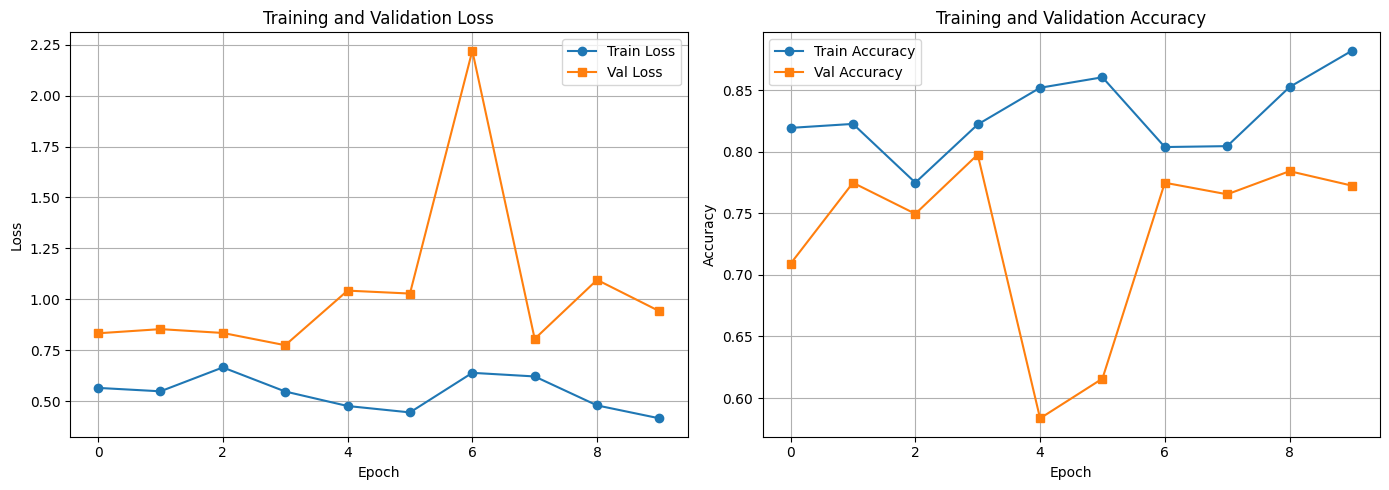


Training history plot saved!


In [24]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accuracies, label='Train Accuracy', marker='o')
axes[1].plot(val_accuracies, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/rsna/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining history plot saved!")


ROC Curve and Optimal Threshold

<>:121: SyntaxWarning: invalid escape sequence '\R'
<>:121: SyntaxWarning: invalid escape sequence '\R'
/tmp/ipython-input-3013942816.py:121: SyntaxWarning: invalid escape sequence '\R'
  print("\ROC analysis complete")


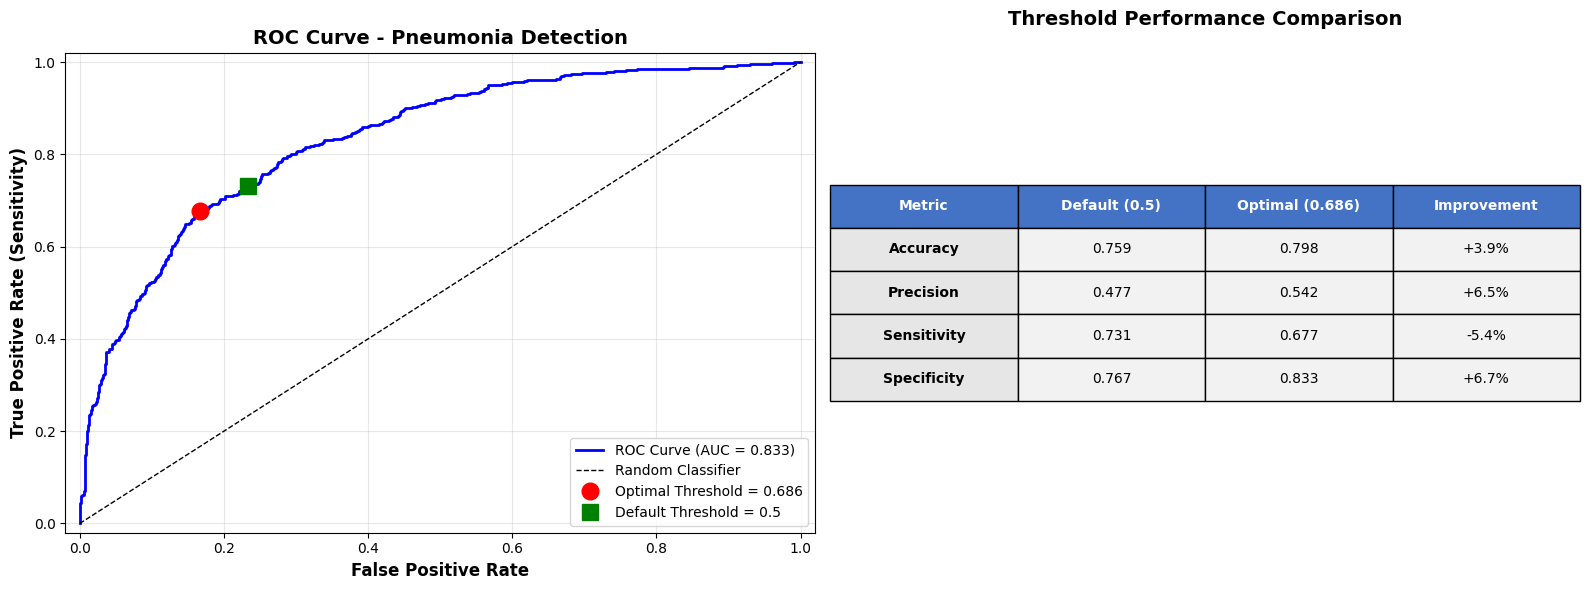


ROC Curve and Optimal Threshold Analysis

ROC-AUC Score: 0.8332

Optimal Threshold: 0.686 (Youden's J statistic)
  - Maximizes Sensitivity + Specificity - 1
  - Sensitivity = 0.677, Specificity = 0.833

Threshold Performance Comparison:
Metric          Default (0.5)   Optimal (0.686)     Improvement
----------------------------------------------------------------------
Accuracy        0.759           0.798                +3.9%
Precision       0.477           0.542                +6.5%
Sensitivity     0.731           0.677                -5.4%
Specificity     0.767           0.833                +6.7%

Interpretation
Optimal threshold (0.686)
Optimal threshold is > 0.5 (less sensitive, might miss more cases)
\ROC analysis complete


In [25]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc_val = auc(fpr, tpr)

# Find optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

# Calculate performance at optimal threshold
optimal_predictions = (all_probs >= optimal_threshold).astype(int)
optimal_accuracy = accuracy_score(all_labels, optimal_predictions)
optimal_precision = precision_score(all_labels, optimal_predictions)
optimal_recall = recall_score(all_labels, optimal_predictions)
optimal_specificity = recall_score(all_labels, optimal_predictions, pos_label=0)

# Calculate performance at default threshold (0.5)
default_accuracy = accuracy_score(all_labels, all_predictions)
default_precision = precision_score(all_labels, all_predictions)
default_recall = recall_score(all_labels, all_predictions)
default_specificity = recall_score(all_labels, all_predictions, pos_label=0)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ROC Curve
axes[0].plot(fpr, tpr, 'b-', lw=2, label=f'ROC Curve (AUC = {roc_auc_val:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
axes[0].plot(optimal_fpr, optimal_tpr, 'ro', markersize=12,
             label=f'Optimal Threshold = {optimal_threshold:.3f}')
axes[0].plot(fpr[np.argmin(np.abs(thresholds - 0.5))],
             tpr[np.argmin(np.abs(thresholds - 0.5))],
             'gs', markersize=12, label='Default Threshold = 0.5')
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curve - Pneumonia Detection', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([-0.02, 1.02])
axes[0].set_ylim([-0.02, 1.02])

# Plot 2: Threshold Comparison Table
axes[1].axis('off')

table_data = [
    ['Metric', 'Default (0.5)', f'Optimal ({optimal_threshold:.3f})', 'Improvement'],
    ['Accuracy', f'{default_accuracy:.3f}', f'{optimal_accuracy:.3f}',
     f'{(optimal_accuracy - default_accuracy)*100:+.1f}%'],
    ['Precision', f'{default_precision:.3f}', f'{optimal_precision:.3f}',
     f'{(optimal_precision - default_precision)*100:+.1f}%'],
    ['Sensitivity', f'{default_recall:.3f}', f'{optimal_recall:.3f}',
     f'{(optimal_recall - default_recall)*100:+.1f}%'],
    ['Specificity', f'{default_specificity:.3f}', f'{optimal_specificity:.3f}',
     f'{(optimal_specificity - default_specificity)*100:+.1f}%'],
]

# Create table
table = axes[1].table(cellText=table_data, cellLoc='center', loc='center',
                      colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

#Header rows
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white')

#Data rows
for i in range(1, 5):
    for j in range(4):
        cell = table[(i, j)]
        if j == 0:
            cell.set_facecolor('#E7E6E6')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('#F2F2F2')

axes[1].set_title('Threshold Performance Comparison',
                  fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/rsna/roc_curve_threshold_analysis.png',
            dpi=150, bbox_inches='tight')
plt.show()

#Results
print("\n" + "="*70)
print("ROC Curve and Optimal Threshold Analysis")
print("="*70)
print(f"\nROC-AUC Score: {roc_auc_val:.4f}")
print(f"\nOptimal Threshold: {optimal_threshold:.3f} (Youden's J statistic)")
print(f"  - Maximizes Sensitivity + Specificity - 1")
print(f"  - Sensitivity = {optimal_tpr:.3f}, Specificity = {1-optimal_fpr:.3f}")

print(f"\n{'Threshold Performance Comparison:'}")
print(f"{'Metric':<15} {'Default (0.5)':<15} {'Optimal ({:.3f})':<20} {'Improvement'}".format(optimal_threshold))
print("-"*70)
print(f"{'Accuracy':<15} {default_accuracy:<15.3f} {optimal_accuracy:<20.3f} {(optimal_accuracy-default_accuracy)*100:+.1f}%")
print(f"{'Precision':<15} {default_precision:<15.3f} {optimal_precision:<20.3f} {(optimal_precision-default_precision)*100:+.1f}%")
print(f"{'Sensitivity':<15} {default_recall:<15.3f} {optimal_recall:<20.3f} {(optimal_recall-default_recall)*100:+.1f}%")
print(f"{'Specificity':<15} {default_specificity:<15.3f} {optimal_specificity:<20.3f} {(optimal_specificity-default_specificity)*100:+.1f}%")

print("\n" + "="*70)
print("Interpretation")
print("="*70)
print(f"Optimal threshold ({optimal_threshold:.3f})")

if optimal_threshold < 0.5:
    print(f"Optimal threshold is < 0.5 (more sensitive, more false alarms)")
elif optimal_threshold > 0.5:
    print(f"Optimal threshold is > 0.5 (less sensitive, might miss more cases)")
else:
    print(f"Optimal threshold equals default")

print("\ROC analysis complete")

Grad-CAM Visualization


Grad-Cam Analysis: Visualization of Correct and Incorrect Predictions


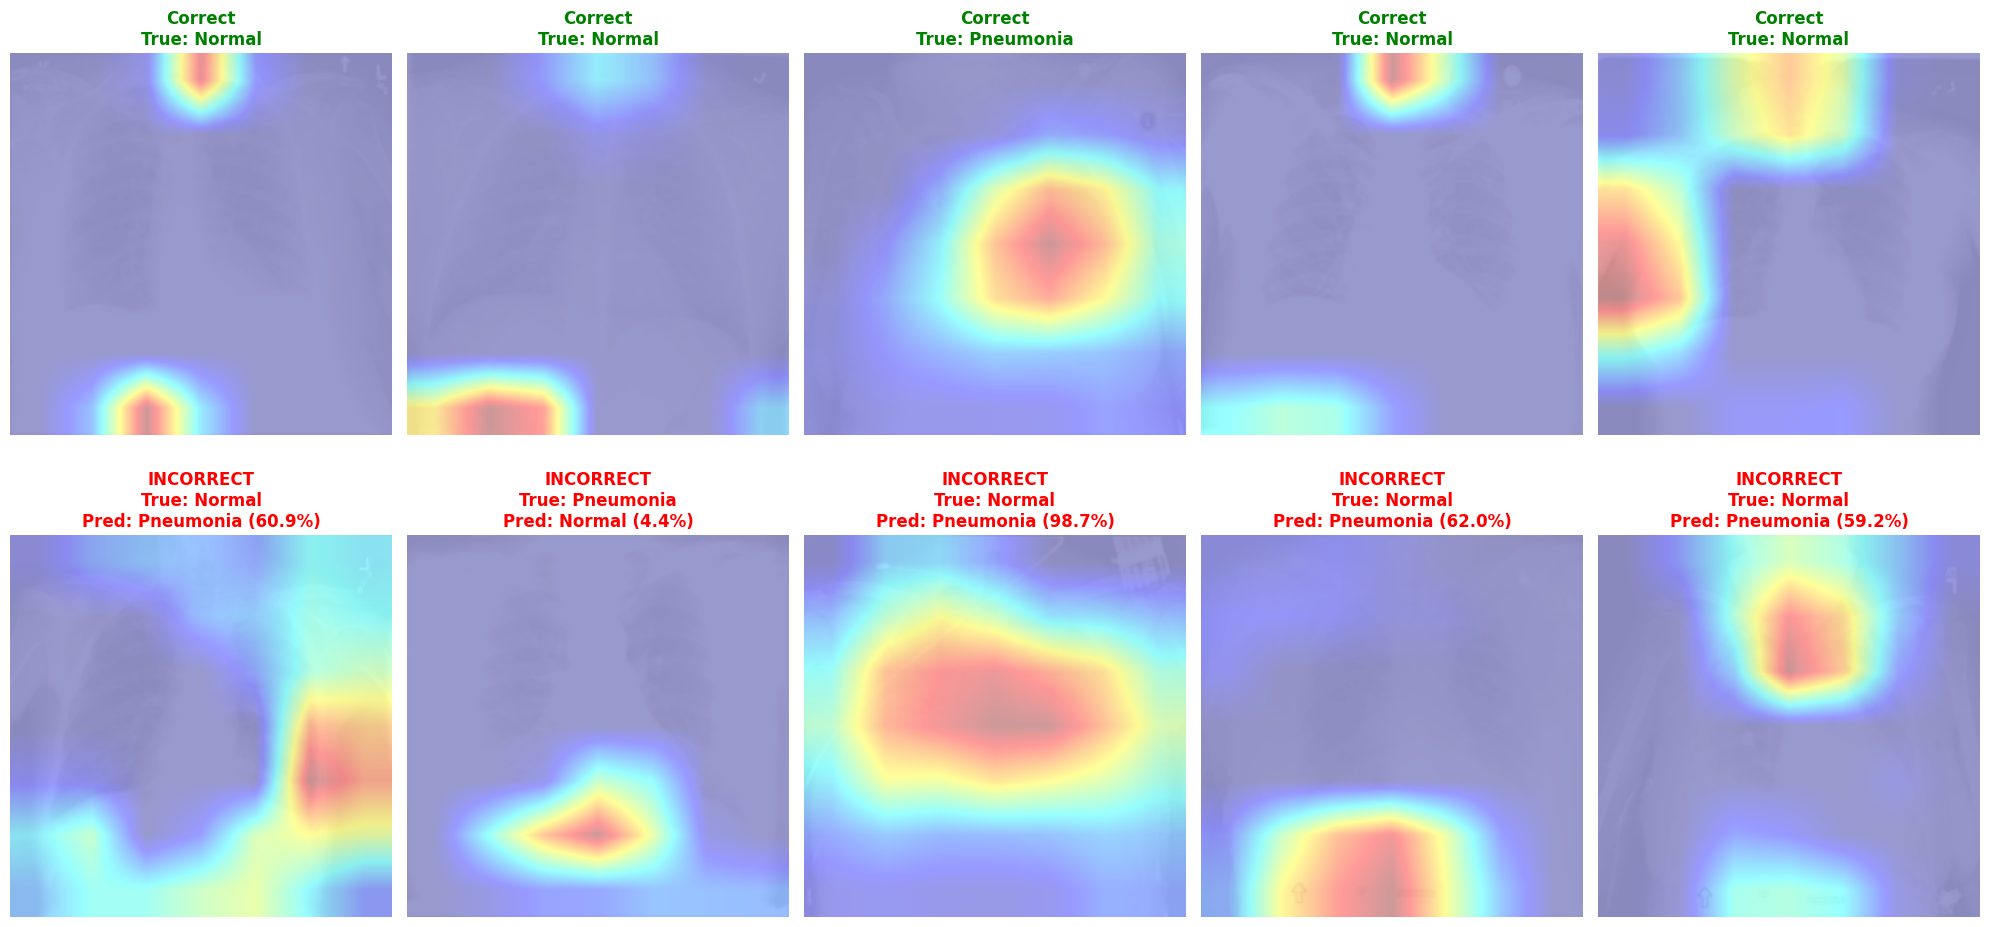

In [27]:
#Grad-Cam Visualization
print("\n" + "="*50)
print("Grad-Cam Analysis: Visualization of Correct and Incorrect Predictions")
print("="*50)

# Find indices of correct and incorrect predictions
correct_indices = []
incorrect_indices = []

for i in range(len(all_predictions)):
    if all_predictions[i] == all_labels[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

# Sample from each category
num_each = 5
correct_samples = np.random.choice(correct_indices, min(num_each, len(correct_indices)), replace=False)
incorrect_samples = np.random.choice(incorrect_indices, min(num_each, len(incorrect_indices)), replace=False)

fig, axes = plt.subplots(2, num_each, figsize=(20, 10))

# Plot correct predictions
for col_idx, test_idx in enumerate(correct_samples):
    original_image, true_label = test_dataset[test_idx]
    input_tensor = original_image.unsqueeze(0).to(device)

    model.zero_grad()
    target_layer = model.layer4[-1]  # Last convolutional layer in ResNet-50
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate_cam(input_tensor)

    img_display = original_image.cpu().numpy().transpose(1, 2, 0)
    img_display = img_display * np.array(NORM_STD) + np.array(NORM_MEAN)
    img_display = np.clip(img_display, 0, 1)

    overlayed = overlay_heatmap((img_display * 255).astype(np.uint8), cam, alpha=0.4)

    axes[0, col_idx].imshow(overlayed)
    axes[0, col_idx].set_title(f'Correct\nTrue: {"Pneumonia" if true_label == 1 else "Normal"}',
                               color='green', fontweight='bold')
    axes[0, col_idx].axis('off')

# Plot incorrect predictions
for col_idx, test_idx in enumerate(incorrect_samples):
    original_image, true_label = test_dataset[test_idx]
    input_tensor = original_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_prob = torch.sigmoid(output).item()
        pred_label = 1 if pred_prob > 0.5 else 0

    model.zero_grad()
    cam = gradcam.generate_cam(input_tensor)

    img_display = original_image.cpu().numpy().transpose(1, 2, 0)
    img_display = img_display * np.array(NORM_STD) + np.array(NORM_MEAN)
    img_display = np.clip(img_display, 0, 1)

    overlayed = overlay_heatmap((img_display * 255).astype(np.uint8), cam, alpha=0.4)

    axes[1, col_idx].imshow(overlayed)
    axes[1, col_idx].set_title(
        f'INCORRECT\nTrue: {"Pneumonia" if true_label == 1 else "Normal"}\n'
        f'Pred: {"Pneumonia" if pred_label == 1 else "Normal"} ({pred_prob:.1%})',
        color='red', fontweight='bold'
    )
    axes[1, col_idx].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/rsna/gradcam_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

Multi-Layer Grad-CAM


Multi-Layer Grad-CAM


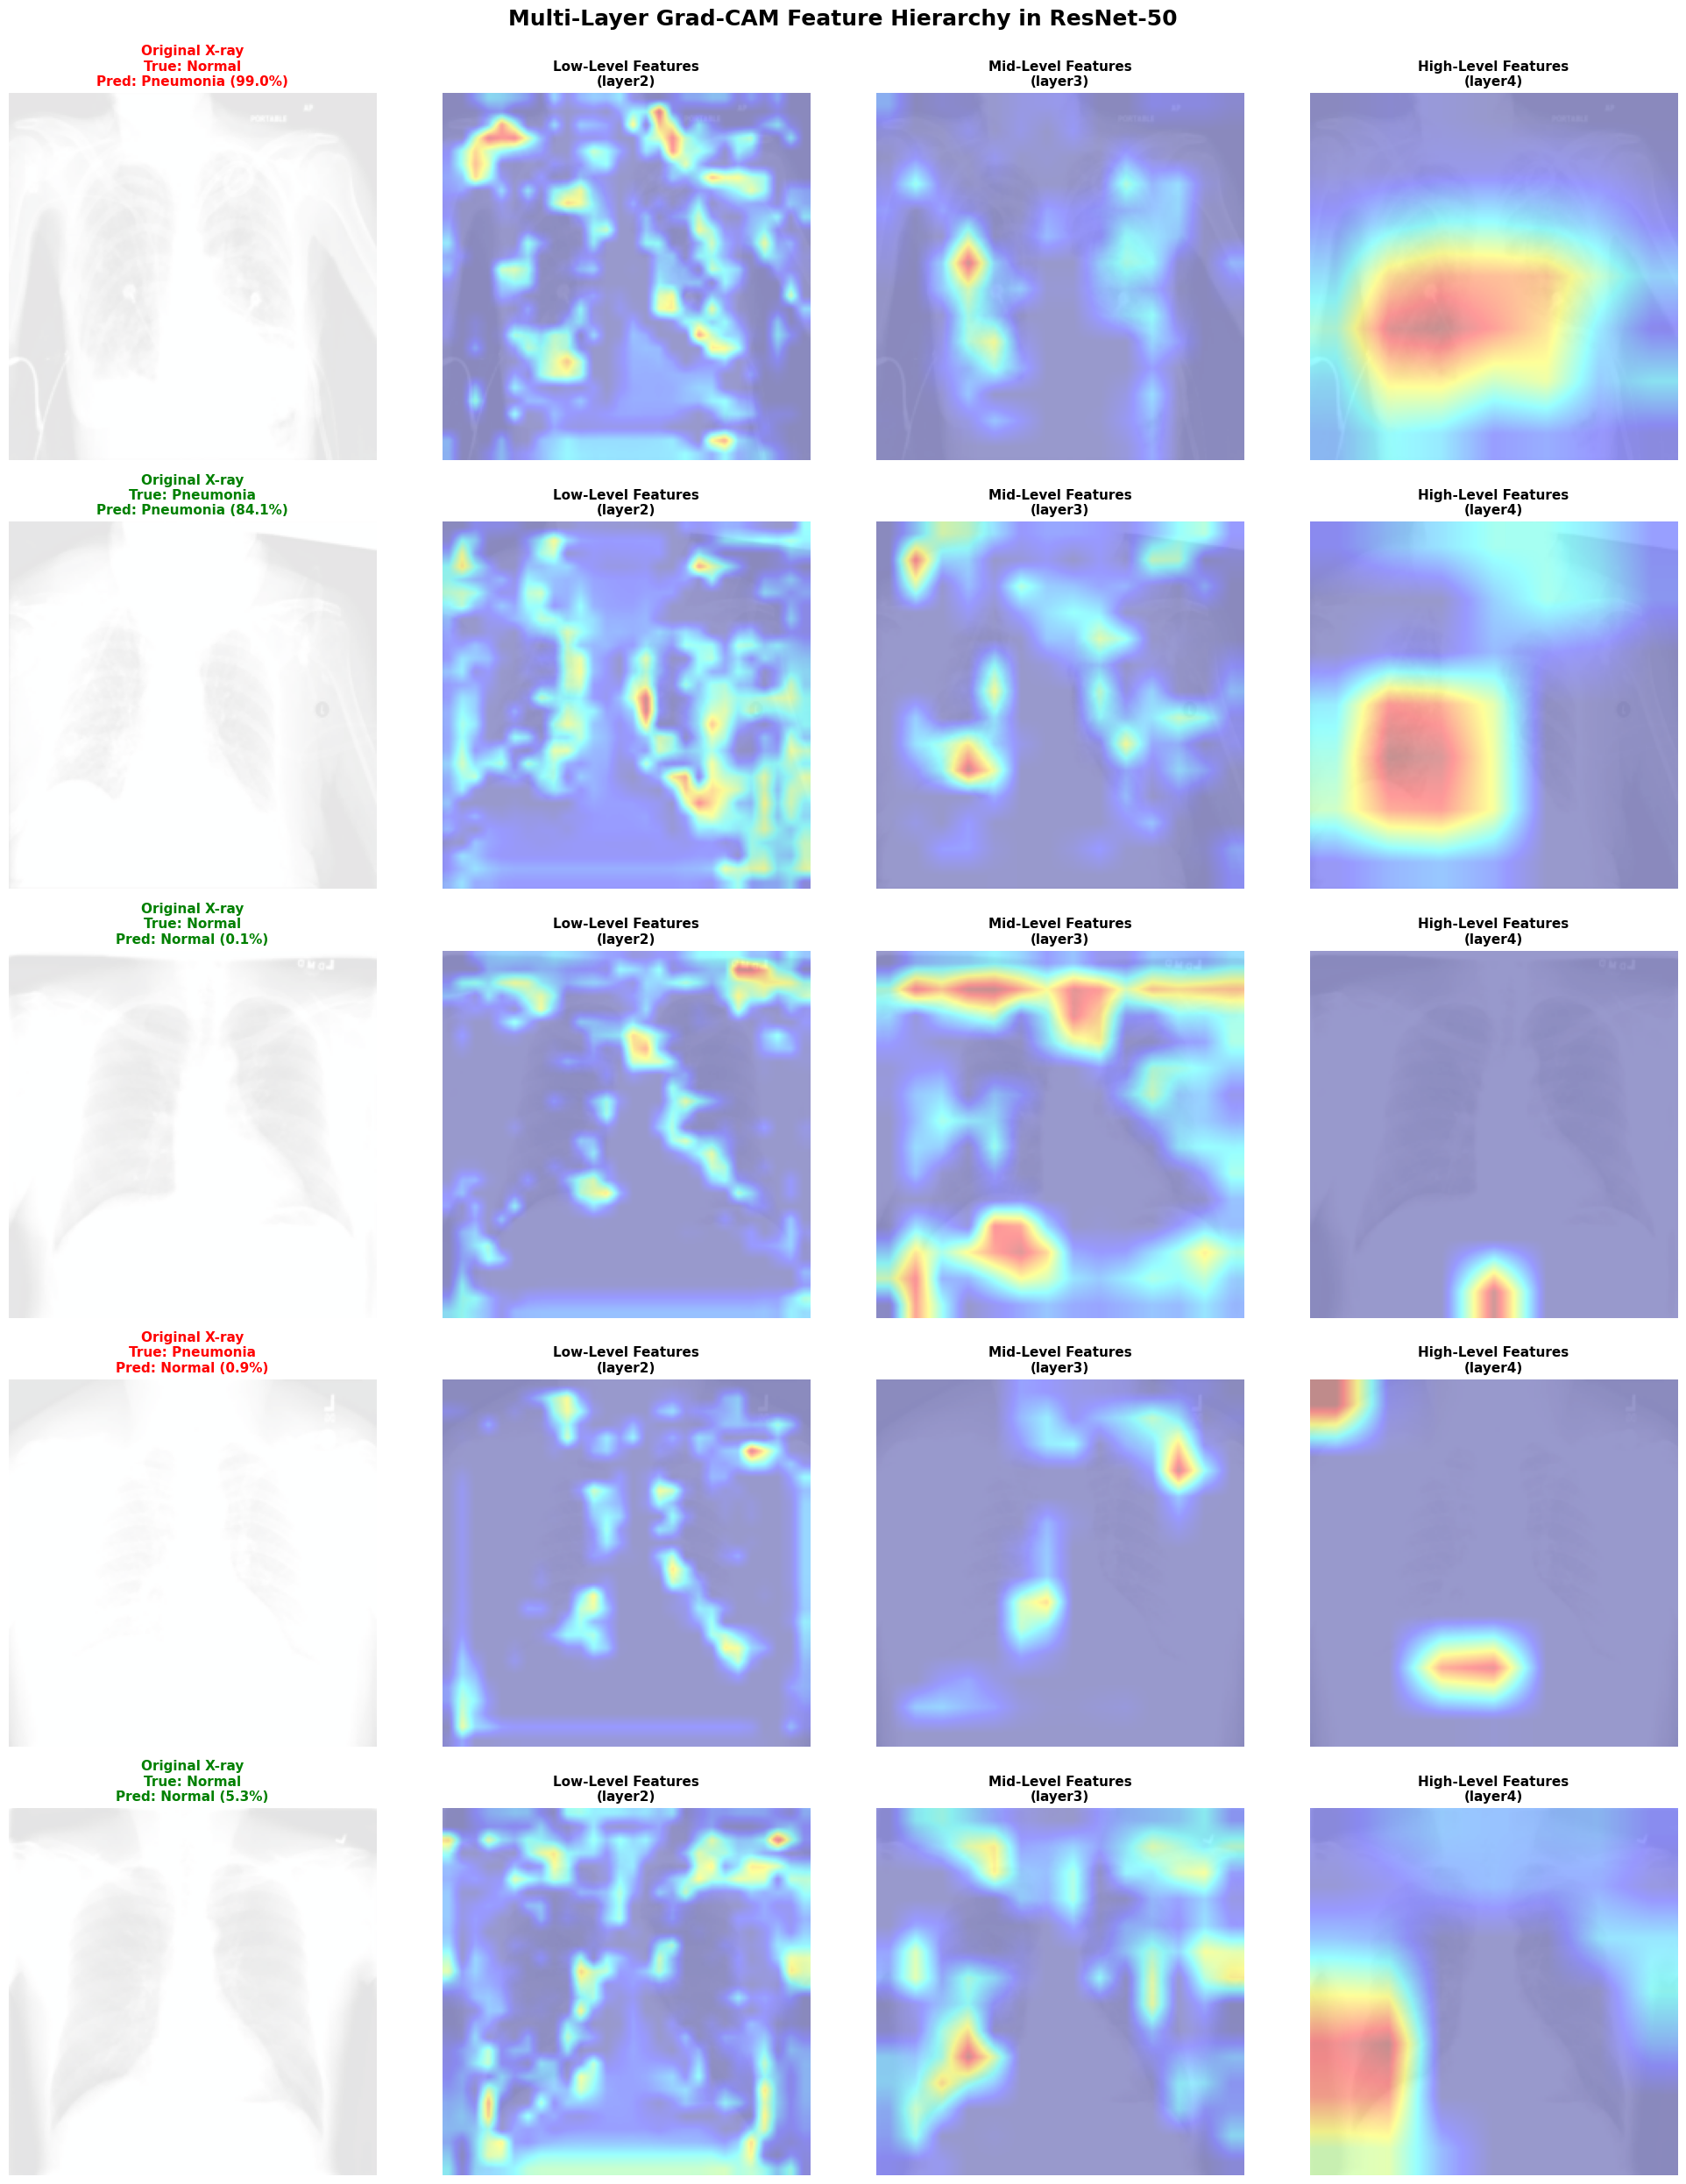


Layers:
  Layer 2: highlights rib edges, diaphragm, and chest wall

  Layer 3: distinguishes between lung texture variations

  Layer 4: highlights regions with pneumonia presence


In [28]:
print("\n" + "="*70)
print("Multi-Layer Grad-CAM")
print("="*70)
# Select diverse samples for visualization
num_samples = 5
sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

# Define layers to visualize
layers_to_visualize = [
    ('layer2', model.layer2[-1], 'Low-Level'),
    ('layer3', model.layer3[-1], 'Mid-Level'),
    ('layer4', model.layer4[-1], 'High-Level')
]

# Create figure
fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
fig.suptitle('Multi-Layer Grad-CAM Feature Hierarchy in ResNet-50',
             fontsize=18, fontweight='bold', y=0.995)

for sample_idx, test_idx in enumerate(sample_indices):
    # Get image and prediction
    original_image, true_label = test_dataset[test_idx]
    input_tensor = original_image.unsqueeze(0).to(device)

    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_prob = torch.sigmoid(output).item()
        pred_label = 1 if pred_prob > 0.5 else 0

    # Denormalize image for display
    img_display = original_image.cpu().numpy().transpose(1, 2, 0)
    img_display = img_display * np.array(NORM_STD) + np.array(NORM_MEAN)
    img_display = np.clip(img_display, 0, 1)

    # Plot original image
    axes[sample_idx, 0].imshow(img_display)
    axes[sample_idx, 0].set_title(
        f'Original X-ray\n'
        f'True: {"Pneumonia" if true_label == 1 else "Normal"}\n'
        f'Pred: {"Pneumonia" if pred_label == 1 else "Normal"} ({pred_prob:.1%})',
        fontsize=11, fontweight='bold',
        color='green' if pred_label == true_label else 'red'
    )
    axes[sample_idx, 0].axis('off')

    # Generate Grad-CAM for each layer
    for layer_idx, (layer_name, target_layer, level_name) in enumerate(layers_to_visualize):
        model.zero_grad()
        gradcam = GradCAM(model, target_layer)
        cam = gradcam.generate_cam(input_tensor)

        # Create overlay
        overlayed = overlay_heatmap((img_display * 255).astype(np.uint8), cam, alpha=0.4)

        # Plot
        axes[sample_idx, layer_idx + 1].imshow(overlayed)
        axes[sample_idx, layer_idx + 1].set_title(
            f'{level_name} Features\n({layer_name})',
            fontsize=11, fontweight='bold'
        )
        axes[sample_idx, layer_idx + 1].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/rsna/multilayer_gradcam_analysis.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("Layers:")
print("="*70)
print("  Layer 2: highlights rib edges, diaphragm, and chest wall")
print("\n  Layer 3: distinguishes between lung texture variations")
print("\n  Layer 4: highlights regions with pneumonia presence")

Side-By-Side Layer Analysis


Layer-by-Layer Analysis


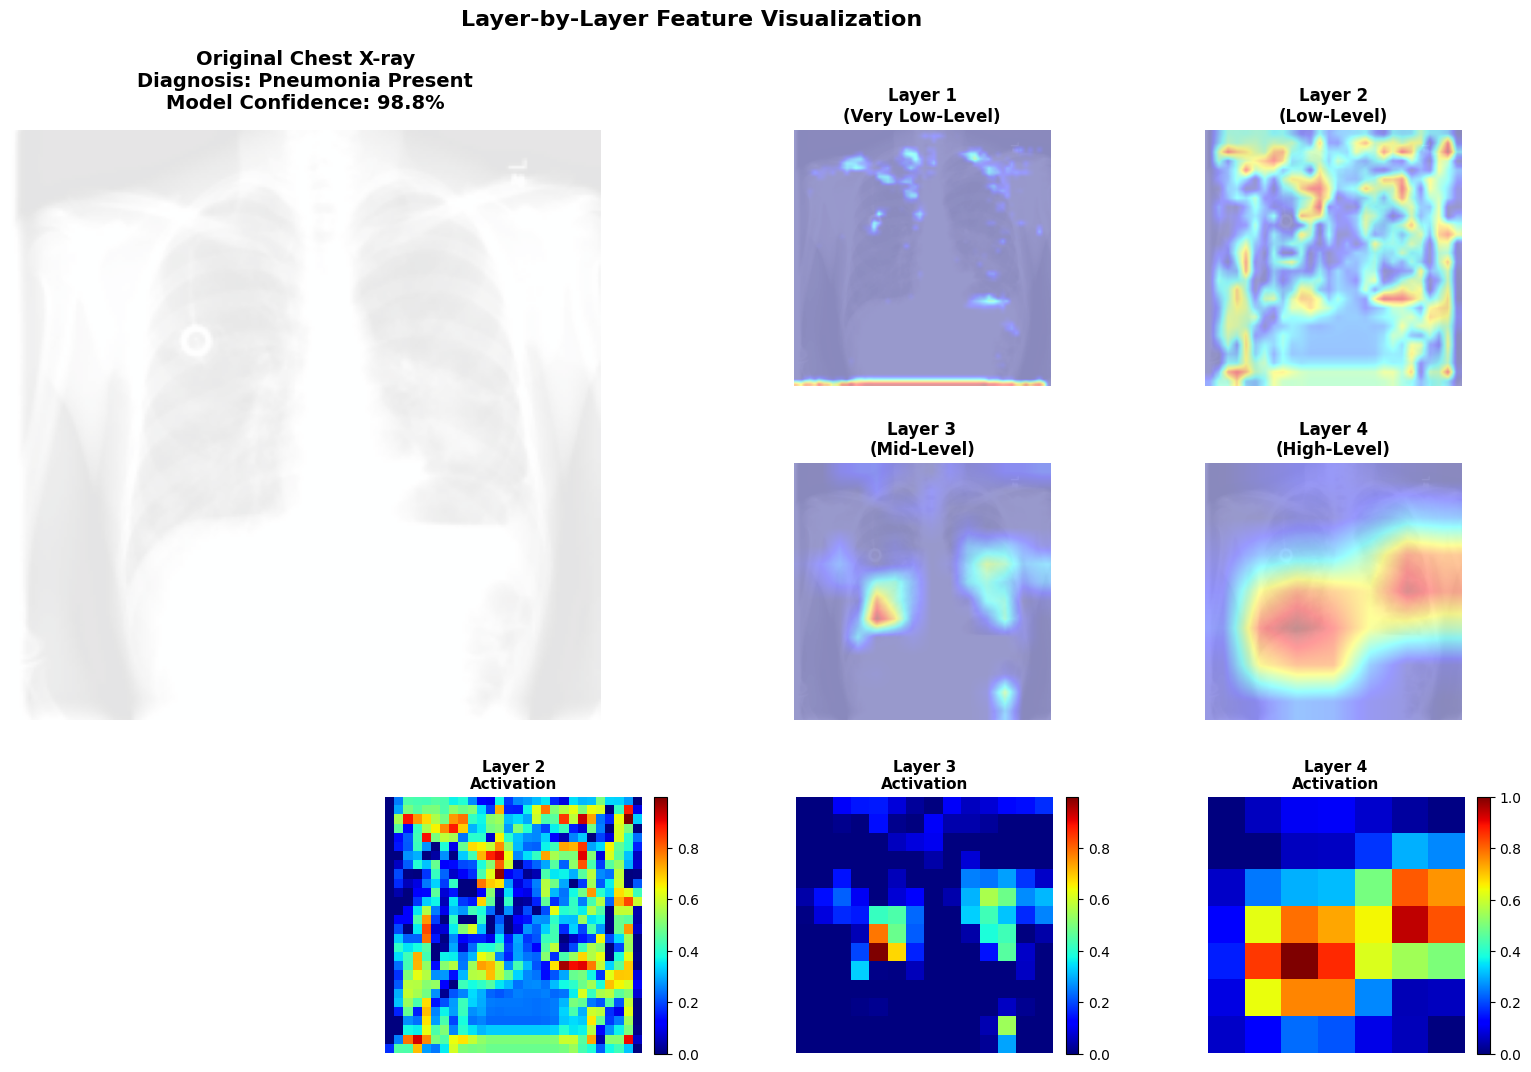


Confidence: 98.8%

Analysis complete


In [29]:
print("\n" + "="*70)
print("Layer-by-Layer Analysis")
print("="*70)

# Select one interesting case (e.g., a true positive with high confidence)
# Find a confident pneumonia prediction
pneumonia_indices = np.where((all_predictions == 1) & (all_labels == 1) & (all_probs > 0.8))[0]

if len(pneumonia_indices) > 0:
    selected_idx = np.random.choice(pneumonia_indices)

    original_image, true_label = test_dataset[selected_idx]
    input_tensor = original_image.unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_prob = torch.sigmoid(output).item()

    # Denormalize
    img_display = original_image.cpu().numpy().transpose(1, 2, 0)
    img_display = img_display * np.array(NORM_STD) + np.array(NORM_MEAN)
    img_display = np.clip(img_display, 0, 1)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))

    # Define grid
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

    # Original image
    ax_orig = fig.add_subplot(gs[0:2, 0:2])
    ax_orig.imshow(img_display)
    ax_orig.set_title(
        f'Original Chest X-ray\n'
        f'Diagnosis: Pneumonia Present\n'
        f'Model Confidence: {pred_prob:.1%}',
        fontsize=14, fontweight='bold', pad=15
    )
    ax_orig.axis('off')

    # Layer visualizations
    layers_detailed = [
        ('layer1', model.layer1[-1], 'Layer 1\n(Very Low-Level)'),
        ('layer2', model.layer2[-1], 'Layer 2\n(Low-Level)'),
        ('layer3', model.layer3[-1], 'Layer 3\n(Mid-Level)'),
        ('layer4', model.layer4[-1], 'Layer 4\n(High-Level)')
    ]

    positions = [
        (0, 2), (0, 3),
        (1, 2), (1, 3)
    ]

    for (layer_name, target_layer, title), (row, col) in zip(layers_detailed, positions):
        model.zero_grad()
        gradcam = GradCAM(model, target_layer)
        cam = gradcam.generate_cam(input_tensor)

        overlayed = overlay_heatmap((img_display * 255).astype(np.uint8), cam, alpha=0.4)

        ax = fig.add_subplot(gs[row, col])
        ax.imshow(overlayed)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')

    # Heatmaps only (bottom row)
    heatmap_layers = [
        ('layer2', model.layer2[-1], 'Layer 2\nActivation'),
        ('layer3', model.layer3[-1], 'Layer 3\nActivation'),
        ('layer4', model.layer4[-1], 'Layer 4\nActivation')
    ]

    for idx, (layer_name, target_layer, title) in enumerate(heatmap_layers):
        model.zero_grad()
        gradcam = GradCAM(model, target_layer)
        cam = gradcam.generate_cam(input_tensor)

        ax = fig.add_subplot(gs[2, idx+1])
        im = ax.imshow(cam, cmap='jet')
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle('Layer-by-Layer Feature Visualization',
                 fontsize=16, fontweight='bold')

    plt.savefig('/content/drive/My Drive/rsna/detailed_layer_analysis.png',
                dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nConfidence: {pred_prob:.1%}")
else:
    print("No high-confidence pneumonia predictions found in test set")

print("\nAnalysis complete")

In [ ]:
!git clone https://github.com/jgirard5/uva-machine-learning-25f-projects.git
